# **Ex8. 영화리뷰 텍스트 감성분석하기**

In [4]:
import os
# install konlpy, jdk, JPype
!pip install konlpy
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip3 install JPype1-py3

# install mecab-ko
os.chdir('/tmp/')
!curl -LO https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
!tar zxfv mecab-0.996-ko-0.9.2.tar.gz
os.chdir('/tmp/mecab-0.996-ko-0.9.2')
!./configure
!make
!make check
!make install

# install mecab-ko-dic
!apt-get install automake
os.chdir('/tmp')
!curl -LO https://bitbucket.org/eunjeon/mecab-ko-dic/downloads/mecab-ko-dic-2.1.1-20180720.tar.gz
!tar -zxvf mecab-ko-dic-2.1.1-20180720.tar.gz
os.chdir('/tmp/mecab-ko-dic-2.1.1-20180720')
!./autogen.sh
!./configure
!make
!make install

# install mecab-python
os.chdir('/content')
!git clone https://bitbucket.org/eunjeon/mecab-python-0.996.git
os.chdir('/content/mecab-python-0.996')
!python3 setup.py build
!python3 setup.py install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 5.1 MB/s 
     |████████████████████████████████| 453 kB 68.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.7 MB/s 
  Created wheel for JPype1-py3: filename=JPype1_py3-0.5.5.4-cp37-cp37m-linux_x86_64.whl size=2686442 sha256=94884474aabe169eef6a8c301ae8c4ba016f506221e8142f8403096717351982
  Stored in directory: /root/.cache/pip/wheels/e7/d1/09/f55dca0203b0691945bdf0f63d486a0b4d4e5ec4bd78a2502e
Successfully built JPype1-py3
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0  2239k      0 --:--:-- --:--:-- --:--:-- 18.3M
meca

In [5]:
import glob
import os
import re
import numpy as np
import pandas as pd
import konlpy

from collections import Counter

import urllib.request
from konlpy.tag import Okt, Mecab

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant

from gensim.models import KeyedVectors
import gensim
from sklearn.model_selection import train_test_split

from keras.layers import Bidirectional, LSTM, GRU, Dense, Conv1D
from keras.layers import Embedding, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 훈련 데이터, 테스트 데이터 준비
# ~ 이 HOME
train_data = pd.read_table('/content/drive/MyDrive/exploration/Ex8/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/exploration/Ex8/ratings_test.txt')

In [7]:
# 훈련 데이터 살펴보기
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [9]:
# 테스트 데이터 살펴보기
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [10]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [12]:
print(len(X_train)) 
print(len(y_train)) 
print(len(X_test))
print(len(y_test))
print('word_to_index : ',len(word_to_index), type(word_to_index))

146182
146182
49157
49157
word_to_index :  9997 <class 'dict'>


In [23]:
word_to_index

TypeError: ignored

In [24]:
word_to_index["<PAD>"] = 0  # 패딩
word_to_index["<BOS>"] = 1  # 모든 문장의 시작
word_to_index["<UNK>"] = 2  # Unknown을 의미

In [25]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [26]:
# 문장 1개를 활용할 딕셔너리와 함께 주면 단어 인덱스 리스트 벡터로 변환해 주는 함수 
# 모든 문장은 <BOS>로 시작하도록 설정
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode해 주는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 데이터 가공

In [28]:
total_data_text = list(X_train) + list(X_test)
# 텍스트 데이터 문장 길이의 리스트 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장 길이의 평균값, 최대값, 표준편차 각각 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}% 정도가 maxlen 설정값 이내에 포함되어 있네요! '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575% 정도가 maxlen 설정값 이내에 포함되어 있네요! 


In [29]:
# padding을 통해 문장의 길이를 맞춘다.

x_train = pad_sequences(X_train,
                        value=word_to_index["<PAD>"],
                        padding='post', # 혹은 'pre'
                        maxlen=maxlen)

x_test = pad_sequences(X_test,
                       value=word_to_index["<PAD>"],
                       padding='post', # 혹은 'pre'
                       maxlen=maxlen)

print(x_train.shape)
print(x_test.shape)

(146182, 41)
(49157, 41)


In [30]:
# 훈련 데이터 앞쪽 10000개 까지 validation set으로 사용
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지는 모두 훈련 데이터로 사용
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


# Validation

In [31]:
vocab_size = 10000  # 단어 사전의 크기를 지정
word_vector_dim = 4   # 한 단어를 표현하는 임베딩 벡터의 차원의 개수

In [32]:
# 1-D CNN 모델 구성

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(32, 3, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 3, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 4)           40000     
                                                                 
 conv1d (Conv1D)             (None, None, 32)          416       
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 32)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1552      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 8)                 1

In [33]:
# 1-D CNN 모델 학습

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=4

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=64,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/4
2128/2128 [==============================] - 15s 7ms/step - loss: 0.4005 - accuracy: 0.8146 - val_loss: 0.3429 - val_accuracy: 0.8487
Epoch 2/4
2128/2128 [==============================] - 13s 6ms/step - loss: 0.3173 - accuracy: 0.8657 - val_loss: 0.3344 - val_accuracy: 0.8523
Epoch 3/4
2128/2128 [==============================] - 14s 7ms/step - loss: 0.2924 - accuracy: 0.8778 - val_loss: 0.3380 - val_accuracy: 0.8502
Epoch 4/4
2128/2128 [==============================] - 13s 6ms/step - loss: 0.2728 - accuracy: 0.8876 - val_loss: 0.3571 - val_accuracy: 0.8462


In [40]:
# 1-D CNN 모델 평가

results = model.evaluate(x_test, y_test, verbose=2)

print(results)

1537/1537 - 1s - loss: 0.3869 - accuracy: 0.8318 - 1s/epoch - 875us/step
[0.3869026303291321, 0.8318449258804321]


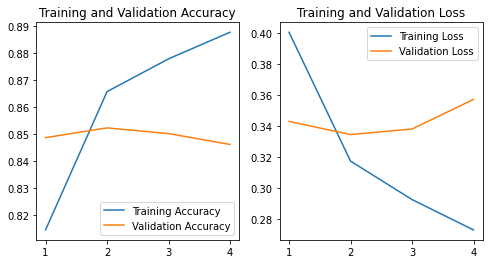

In [36]:
# Accuracy, Loss 그래프 시각화

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
# GlobalMaxPooling1D 모델 구성

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 4)           40000     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 4)                0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 8)                 40        
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 40,049
Trainable params: 40,049
Non-trainable params: 0
_________________________________________________________________


In [38]:
# GlobalMaxPooling1D 모델 학습

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=64,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
2128/2128 [==============================] - 4s 2ms/step - loss: 0.4715 - accuracy: 0.7820 - val_loss: 0.3822 - val_accuracy: 0.8291
Epoch 2/5
2128/2128 [==============================] - 4s 2ms/step - loss: 0.3651 - accuracy: 0.8407 - val_loss: 0.3712 - val_accuracy: 0.8353
Epoch 3/5
2128/2128 [==============================] - 4s 2ms/step - loss: 0.3395 - accuracy: 0.8534 - val_loss: 0.3709 - val_accuracy: 0.8366
Epoch 4/5
2128/2128 [==============================] - 4s 2ms/step - loss: 0.3252 - accuracy: 0.8608 - val_loss: 0.3755 - val_accuracy: 0.8378
Epoch 5/5
2128/2128 [==============================] - 4s 2ms/step - loss: 0.3150 - accuracy: 0.8660 - val_loss: 0.3775 - val_accuracy: 0.8399


In [41]:
# GlobalMaxPooling1D 모델 평가

results = model.evaluate(x_test, y_test, verbose=2)

print(results)

1537/1537 - 1s - loss: 0.3869 - accuracy: 0.8318 - 1s/epoch - 938us/step
[0.3869026303291321, 0.8318449258804321]


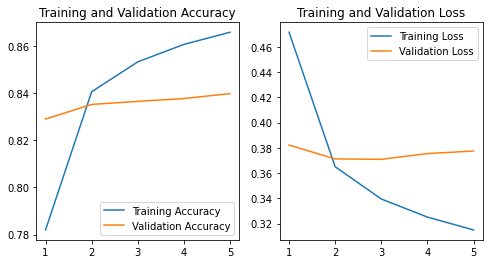

In [42]:
# Accuracy, Loss 그래프 시각화

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [43]:
# LSTM 레이어 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))  #LSTM state 벡터의 차원수
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  #최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 4)           40000     
                                                                 
 lstm (LSTM)                 (None, 8)                 416       
                                                                 
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 40,497
Trainable params: 40,497
Non-trainable params: 0
_________________________________________________________________


In [44]:
# LSTM 레이어 모델 학습

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=64,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
2128/2128 [==============================] - 30s 13ms/step - loss: 0.4239 - accuracy: 0.7921 - val_loss: 0.3434 - val_accuracy: 0.8504
Epoch 2/5
2128/2128 [==============================] - 28s 13ms/step - loss: 0.3314 - accuracy: 0.8570 - val_loss: 0.3356 - val_accuracy: 0.8539
Epoch 3/5
2128/2128 [==============================] - 27s 12ms/step - loss: 0.3134 - accuracy: 0.8638 - val_loss: 0.3369 - val_accuracy: 0.8520
Epoch 4/5
2128/2128 [==============================] - 26s 12ms/step - loss: 0.3025 - accuracy: 0.8687 - val_loss: 0.3466 - val_accuracy: 0.8519
Epoch 5/5
2128/2128 [==============================] - 26s 12ms/step - loss: 0.2904 - accuracy: 0.8736 - val_loss: 0.3483 - val_accuracy: 0.8509


In [45]:
# LSTM 모델 평가

results = model.evaluate(x_test, y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3566 - accuracy: 0.8482 - 4s/epoch - 2ms/step
[0.35663822293281555, 0.8481802940368652]


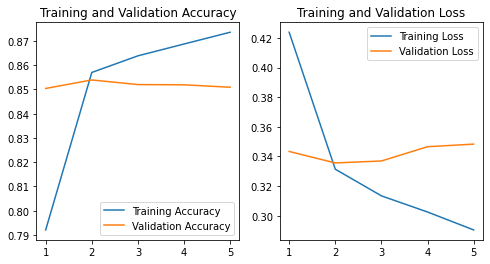

In [46]:
# Accuracy, Loss 그래프 시각화

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 한글화

In [47]:
import os
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

# 임베딩 레이어 차원 확인
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # 출력 형태 : (vocab_size, embedding_dim)

(10000, 4)


In [49]:
# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = '/content/drive/MyDrive/exploration/Ex8/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 기록

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [50]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
# 파일에 기록된 임베딩 파라미터를 읽어서 word vector로 활용
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

# 유사한 단어와 그 유사도 확인
word_vectors.similar_by_word("사랑")

[('상영관', 0.9991036653518677),
 ('영화제', 0.9990578889846802),
 ('다시', 0.998960018157959),
 ('1992', 0.9987898468971252),
 ('슬프', 0.998788595199585),
 ('~^^', 0.9981533885002136),
 ('아름답', 0.9981186985969543),
 ('봣', 0.9980881214141846),
 ('바지', 0.9980648756027222),
 ('아아아아', 0.99799644947052)]

In [51]:
# gensim 패키지 버전 알아보기

import gensim
gensim.__version__

'3.6.0'

In [61]:
# 한국어 Word2Vec 파일 불러와 ko_model에 저장하기
from gensim.models import KeyedVectors

word2vec_path = '/content/drive/MyDrive/exploration/Ex8/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['희망']
vector.shape     # 200dim의 워드 벡터

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(200,)

In [63]:
word2vec.wv.most_similar('희망')  # 학습이 잘 되어 유사함

[('열망', 0.571174144744873),
 ('행복', 0.5318456888198853),
 ('소망', 0.5299249887466431),
 ('염원', 0.5261855721473694),
 ('기쁨', 0.5192784070968628),
 ('갈망', 0.5077978372573853),
 ('기대', 0.49611741304397583),
 ('꿈', 0.49124279618263245),
 ('열정', 0.4850333631038666),
 ('약속', 0.48367926478385925)]

In [64]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000     # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩 차례대로 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [65]:
# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 41, 200)           2000000   
                                                                 
 lstm_1 (LSTM)               (None, 128)               168448    
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,168,577
Trainable params: 2,168,577
Non-trainable params: 0
_________________________________________________________________


In [66]:
# 학습 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
2128/2128 [==============================] - 146s 68ms/step - loss: 0.4205 - accuracy: 0.7930 - val_loss: 0.3267 - val_accuracy: 0.8593
Epoch 2/5
2128/2128 [==============================] - 147s 69ms/step - loss: 0.2940 - accuracy: 0.8750 - val_loss: 0.3075 - val_accuracy: 0.8681
Epoch 3/5
2128/2128 [==============================] - 152s 71ms/step - loss: 0.2514 - accuracy: 0.8959 - val_loss: 0.3065 - val_accuracy: 0.8699
Epoch 4/5
2128/2128 [==============================] - 156s 73ms/step - loss: 0.2137 - accuracy: 0.9130 - val_loss: 0.3143 - val_accuracy: 0.8703
Epoch 5/5
2128/2128 [==============================] - 154s 72ms/step - loss: 0.1785 - accuracy: 0.9302 - val_loss: 0.3312 - val_accuracy: 0.8683


In [68]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)   # 정확도가 0.86으로 개선됨

ValueError: ignored

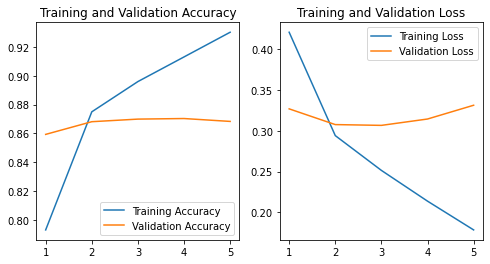

In [69]:
# 시각화할 항목 세팅
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()